# Chapter 5. Classification

**Classification and propensity score**: 
1. Establish a cutoff probability for the class of interest, above which we consider a record as belonging to that class
2. Estimate with any model the probability that a record belongs to the class of interest
3. If that probability is above the cutoff probability, assign the new record to the class of interest 

The higher the cutoff, the fewer the records predicted as belonging to the class of interest. The lower the cutoff, the more the records predicted. 

**More than two categories**: Even in the case of more than two outcomes, the problem can often be recast into a series of binary problems using conditional probabilities. For example Y = 0,1,2. Predict Y = 0 or Y > 0. Given that Y > 0, predict whether Y = 1 or Y = 2. 

## 5.1 Naive bayes

The naive bayes algorithm uses the probability of observing predictor values, given an outcome, to estimate what is really of interest: the probability of observing outcome Y = i, given a set of predictor values 

**Conditional probability**: the probability of observing some event (say, X = i) given some other event (say, Y = i), written as P(Xi | Yi)

**Posterior probability**: the probability of an outcome after the predictor information has been incorporated (in contrast to the prior probability of outcomes, not taking predictor information into account)

**Complete or exact bayesian classification**
For each record to be classified:
1. Find all the other records with the same predictor profile (i.e. where the predictor values are the same)
2. Determine what classes those records belong to and which class is most prevalent (i.e. probable)
3. Assign that class to the new record

Note: predictor variables must be categorical (factor) variables in the standard naive bayes algorithm

### Why exact bayesian classification is impractical

When the number of predictor variables exceeds a handful, many of the records to be classified will be without exact matches. Considering a model to predict voting on the basis of demographic variables. Even a sizable sample may not contain even a single match for a new record who is a male Hispanic with high income from the US Midwest who voted in the last election, did not vote in the prior election, has three daughters and one son, and is divorced. And this is with just eight variables, a small number for most classification problems. The addition of just a single new variable with five equally frequent categories reduces the probability of a match by a factor of 5

### The naive solution

**Naive bayes** we no longer restrict the probability calculation to those records that match the record to be classified. Instead, we use the entire data set. 
1. For a binary response Y = i (i = 0 or 1), estimate the individual conditional probabilities for each predictor P(Xj | Y = i). These are the probabilities that the predictor value is in the record when we observe Y = i. This probability is estimated by the proportion of Xj values among the Y = i records in the training set
2. Multiply these probabilities by each other, and then by the proportion of records belonging to Y = i
3. Repeat steps 1 and 2 for all the classes
4. Estimate a probability for outcome i by taking the value calculated in step 2 for class i and dividing it by the sum of such values for all classes
5. Assign the record to the class with the highest probability for this set of predictor values

**Exact Bayes classification**:

P(Y = i|X1,X2,…,Xp) = P(Y = i)P(X1,…,Xp|Y = i) / P(Y = 0)P(X1,…,Xp|Y = 0) + P(Y = 1)P(X1,…,Xp|Y = 1)...

**Naive bayes**:

Under the naive bayes assumption of conditional independence, the equation changes into:

P(Y = i|X1,X2,…,Xp) = P(Y = i)P(X1|Y = i)…P(Xp|Y = i) / P(Y = 0)P(X1|Y = 0)…P(Xp|Y = 0) + P(Y = 1)P(X1|Y =1)...

Why is this formula called naive? We have made a simplifying assumption that the exact conditional probability of a vector of predictor values, given observing an outcome, is sufficiently well estimated by the product of the individual conditional probabilities P(Xj|Y=i). In other words, in estimating P(Xj|Y=i) instead of P(X1,X2,...Xp|Y=i), we are assuming Xj is independent of all the other predictor variables Xk for k ≠ j

In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB

loan_data = pd.read_csv('/Users/boyuan/Desktop/OneDrive/practical-statistics-for-data-scientists-master/data/loan_data.csv.gz',
                        compression = 'gzip')
loan_data.head()

,Unnamed: 0,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,...,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,...,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,...,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,...,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,...,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,...,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55


In [2]:
# convert to categorical
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])
loan_data.purpose_ = loan_data.purpose_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

In [3]:
predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='')
y = loan_data[outcome]

naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
naive_model.fit(X, y)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [4]:
naive_model.feature_log_prob_

array([[-2.98568079, -1.65075848, -3.91515406, -4.38810745, -5.34359996,
        -3.25614089, -4.18335906, -1.93946238, -3.58417726, -1.82144088,
        -4.15016524, -1.14705315],
       [-2.77207366, -1.69253222, -3.73665122, -4.02494832, -5.34977262,
        -3.40212145, -4.96201704, -1.81302493, -3.6131958 , -1.94345848,
        -4.57066335, -1.13015885]])

In [6]:
new_loan = X.loc[146:146, :]
new_loan

,credit_card,debt_consolidation,home_improvement,major_purchase,medical,other,small_business,MORTGAGE,OWN,RENT,< 1 Year,> 1 Year
146,0,0,0,0,0,0,1,1,0,0,0,1


In [7]:
y[146]

'default'

In [8]:
print('predicted class: ', naive_model.predict(new_loan)[0])
probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                             columns = loan_data[outcome].cat.categories)
print('predicted probabilities', probabilities)

predicted class:  default
predicted probabilities     default  paid off
0  0.653696  0.346304


The naive bayes classifier is known to produce biased estimates. However, where the goal is to rank records according to the probability that Y = 1, unbiased estimates of probability are not needed, and naive bayes produces good results

### Numeric predictor variables

The bayesian classifier works only with categorical predictors (e.g. with spam classification, where the presence or absence of words, phrases, characters, and so on lies at the heart of the predictive task). To apply naive bayes to numerical predictors, one of the two approaches must be taken:
1. Bin and convert the numerical predictors to categorical predictors and apply the algorithm
2. Use a probability model - for example, the normal distribution - to estimate the conditional probability P(Xj|Y=i)

**Caution**: When a predictor category is absent in the training data, the algorithm assigns zero probability to the outcome variable in new data, rather than simply ignoring this variable and using the information from other variables, as other methods might. Most implementations of Naive Bayes use a smoothing parameter (Laplace Smoothing) to prevent this

## 5.2 Discriminant analysis

Covariance: a measure of the extent to which one variable in concert with another (i.e. similar magnitude and direction)

Discriminant function: the function that, when applied to the predictor variables, maximizes the separation of the classes

Discriminant weights: the scores that result from the application of the discriminant function and are used to estimate probabilities of belonging to one class or another

**Linear discriminant analysis, or LDA**: is now less widely used with the advent of more sophisticated techniques, such as tree models and logistic regression

Note: Linear discriminant analysis should not be confused with Latent Dirichlet Allocation, also referred to as LDA. Latent Dirichlet Allocation is used in text and natural language processing and is unrelated to linear discriminant analysis

### Covariance matrix

The covariance measures the relationship between two variables x and z.

As with the correlation coefficient, positive values indicate a positive relationship and negative values indicate a negative relationship. Correlation, however, is constrained to be between –1 and 1, whereas covariance scale depends on the scale of the variables x and z.

### Fisher's linear discriminant

To predict a binary outcome y using just two continuous numeric variables (x, z). Technically, discriminant analysis assumes the predictor variables are normally distributed continuous variables, but, in practice, the method works well even for nonextreme departures from normality, and for binary predictors.

Fisher’s linear discriminant distinguishes variation between groups, on the one hand, from variation within groups on the other. Specifically, seeking to divide the records into two groups, linear discriminant analysis (LDA) focuses on maximizing the “between” sum of squares SSbetween (measuring the variation between the two groups) relative to the “within” sum of squares SSwithin (measuring the within-group variation). In this case, the two groups correspond to the records (x0, z0) for which y = 0 and the records (x1, z1) for which y = 1. The method finds the linear combination wxx + wzz that maximizes that sum of squares ratio: SSbetween/SSwithin

The between sum of squares is the squared distance between the two group means, and the within sum of squares is the spread around the means within each group, weighted by the covariance matrix. Intuitively, by maximizing the between sum of squares and minimizing the within sum of squares, this method yields the greatest separation between the two groups.

### A simple example

In [9]:
loan3000 = pd.read_csv('/Users/boyuan/Desktop/OneDrive/practical-statistics-for-data-scientists-master/data/loan3000.csv')
loan3000.head()

,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio
0,32109,paid off,debt_consolidation,21.23,0.40,5.11135
1,16982,default,credit_card,15.49,0.40,5.43165
2,25335,paid off,debt_consolidation,27.30,0.70,9.23003
3,34580,paid off,major_purchase,21.11,0.40,2.33482
4,14424,default,debt_consolidation,16.46,0.45,12.10320


In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

loan3000.outcome = loan3000.outcome.astype('category')

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)

pd.DataFrame(loan_lda.scalings_, index = X.columns)

,0
borrower_score,7.175839
payment_inc_ratio,-0.099676


**Using discriminant analysis for feature selection**: If the predictor variables are normalized prior to running LDA, the discriminator weights are measures of variable importance, thus providing a computationally efficient method of feature selection

In [13]:
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]),
                    columns = loan_lda.classes_)
pred.head()

,default,paid off
0,0.553544,0.446456
1,0.558953,0.441047
2,0.272696,0.727304
3,0.506254,0.493746
4,0.609952,0.390048


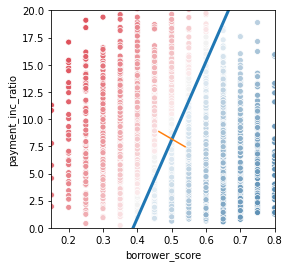

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use scalings and center of means to determine decision boundary
center = np.mean(loan_lda.means_, axis=0)
slope = - loan_lda.scalings_[0] / loan_lda.scalings_[1]
intercept = center[1] - center[0] * slope

# payment_inc_ratio for borrower_score of 0 and 20
x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([loan3000, pred['default']], axis=1)
lda_df.head()

fig, ax = plt.subplots(figsize=(4, 4))
g = sns.scatterplot(x='borrower_score', y='payment_inc_ratio',
                    hue='default', data=lda_df,
                    palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),
                    ax=ax, legend=False)

ax.set_ylim(0, 20)
ax.set_xlim(0.15, 0.8)
ax.plot((x_0, x_20), (0, 20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())

**Extensions of discriminant analysis:** 
1. More predictor variables: while the text and example in this section used just two predictor variables, LDA works just as well with more than two predictor variables. The only limiting factor is the number of records (estimating the covariance matrix requires a sufficient number of records per variable, which is typically not an issue in data science applications).
2. There are other variants of discriminant analysis. The best known is quadratic discriminant analysis (QDA). Despite its name, QDA is still a linear discriminant function. The main difference is that in LDA, the covariance matrix is assumed to be the same for the two groups corresponding to Y = 0 and Y = 1. In QDA, the covariance matrix is allowed to be different for the two groups. In practice, the difference in most applications is not critical.

## 5.3 Logistic regression

Logit (log odds): the function that maps class membership probability to a range from -inf to +inf, instead of 0 to 1 

Odds: the ratio of success (1) to not success (0)

Log odds: the response in the transformed model (now linear), which gets mapped back to a probability

### Logistic response function and logit

log (Odds (Y = 1)) = β0 + β1x1 + β2x2 +⋯+ βqxq

The log-odds function, also known as the logit function, maps the probability p from (0, 1) to any value (−∞,+∞)

We have used a linear model to predict a probability, which we can in turn map to a class label by applying a cutoff rule - any record with a probability greater than the cutoff is classified as a 1

### Logistic regression and the GLM

The response in the logistic regression formula is the log odds of a binary outcome of 1. We observe only the binary outcome, not the log odds, so special statistical methods are needed to fit the equation. Logistic regression is a special instance of a generalized linear model (GLM) developed to extend linear regression to other things 

In [25]:
from sklearn.linear_model import LogisticRegression

predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], prefix = '', prefix_sep = '', drop_first = True)
y = loan_data[outcome]

logit_reg = LogisticRegression(penalty = 'l2', C = 1e42, solver = 'liblinear')
logit_reg.fit(X, y)
logit_reg

LogisticRegression(C=1e+42, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
print('intercept ', logit_reg.intercept_[0])
print('classes', logit_reg.classes_)
pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns)

intercept  -1.6378908225968347
classes ['default' 'paid off']


,coeff
payment_inc_ratio,-0.079739
borrower_score,4.612183
debt_consolidation,-0.249414
home_improvement,-0.407734
major_purchase,-0.229710
medical,-0.510744
other,-0.620800
small_business,-1.214936
OWN,-0.048211
RENT,-0.157288


### Generalized linear models

Generalized linear models (GLM) are characterized by two main components:
1. A probability distribution or family (binomial in the case of logistic regression)
2. A link function - i.e., a transformation function that maps the response to the predictors (logit in the case of logistic regression)

### Predicted values from logistic regression 

The predicted value from logistic regression is in terms of the log odds: ^Y = log (Odds (Y = 1)).

In [27]:
pred = pd.DataFrame(logit_reg.predict_log_proba(X), 
                    columns = loan_data[outcome].cat.categories)
pred.describe()

,default,paid off
count,45342.000000,45342.000000
mean,-0.757872,-0.760434
std,0.378093,0.390456
min,-2.769376,-3.538593
25%,-0.985739,-0.977207
50%,-0.697406,-0.688907
75%,-0.472183,-0.467069
max,-0.029485,-0.064753


In [28]:
pred = pd.DataFrame(logit_reg.predict_proba(X),
                    columns = loan_data[outcome].cat.categories)
pred.describe()

,default,paid off
count,45342.000000,45342.000000
mean,0.500000,0.500000
std,0.167354,0.167354
min,0.062701,0.029054
25%,0.373163,0.376361
50%,0.497875,0.502125
75%,0.623639,0.626837
max,0.970946,0.937299


### Interpreting the coefficients and odds ratios

The odds ratio for a binary factor variable X:

**odds ratio** = Odds(Y=1|X=1) / Odds(Y=1|X=0)

The odds that Y = 1 when X = 1 versus the odds that Y = 1 when X = 0. If the odds ratio is 2, then the odds that Y = 1 are two times higher when X = 1 versus when X = 0. 

The coefficient βj in the logistic regression is the log of the odds ratio for Xj

For example, the model the regression coefficient for purpose_small_business is 1.21526. This means that a loan to a small business compared to a loan to pay off credit card debt reduces the odds of defaulting versus being paid off by exp(1.21526) ≈ 3.4. Clearly, loans for the purpose of creating or expanding a small business are considerably riskier than other types of loans.

The relationship between the odds ratio and the log-odds ratio for odds ratios greater than 1. Because the coefficients are on the log scale, an increase of 1 in the coefficient results in an increase of exp(1) ≈ 2.72 in the odds ratio

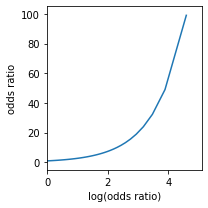

In [30]:
p = np.arange(0.01, 1, 0.01)
df = pd.DataFrame({
    'p': p,
    'logit': np.log(p / (1 - p)),
    'odds': p / (1 - p),
})

fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(df['logit'], df['odds'])
ax.set_xlabel('log(odds ratio)')
ax.set_ylabel('odds ratio')
ax.set_xlim(0, 5.1)
ax.set_ylim(-5, 105)

plt.tight_layout()
plt.show()

Odds ratios for numeric variables X can be interpreted similarly: they measure the change in the odds ratio for a unit change in X

### Linear and logistic regression: similarities and differences

Linear regression and logistic regression share many commonalities. Both assume a parametric linear form relating the predictors with the response. Exploring and finding the best model are done in very similar ways. Extensions to the linear model, like the use of a spline transform of a predictor are equally applicable in the logistic regression setting. Logistic regression differs in two fundamental ways:
1. The way the model is fit (least squares is not applicable)
2. The nature and analysis of the residuals from the model

**Fitting the model**

Linear regression is fit using least squares, and the quality of the fit is evaluated using RMSE and R-squared statistics. In logistic regression (unlike in linear regression), there is no closed-form solution, and the model must be fit using maximum likelihood estimation (MLE). Maximum likelihood estimation is a process that tries to find the model that is most likely to have produced the data we see. In the logistic regression equation, the response is not 0 or 1 but rather an estimate of the log odds that the response is 1. The MLE finds the solution such that the estimated log odds best describes the observed outcome. The mechanics of the algorithm involve a quasi-Newton optimization that iterates between a scoring step (Fisher’s scoring), based on the current parameters, and an update to the parameters to improve the fit.

**Maximum likelihood estimation**:
Start with a set of data (X1,X2,⋯,Xn) and a probability model Pθ (X1,X2,⋯,Xn) that depends on a set of parameters θ. The goal of MLE is to find the set of parameters ˆθ that maximizes the value of Pθ (X1,X2,⋯,Xn); that is, it maximizes the probability of observing (X1,X2,⋯,Xn) given the model P. In the fitting process, the model is evaluated using a metric called deviance: 

deviance = −2 log(Pˆθ (X1,X2,⋯,Xn)).

Lower deviance corresponds to a better fit.

**Handling factor variables:** In logistic regression, factor variables should be coded as in linear regression. In R and other software, this is normally handled automatically, and generally reference encoding is used. All of the other classification methods covered in this chapter typically use the one hot encoder representation. In Python’s scikit-learn, it is easiest to use one hot encoding, which means that only n – 1 of the resulting dummies can be used in the regression.

### Assessing the model

In [34]:
import statsmodels.api as sm

y_numbers = [1 if yi == 'default' else 0 for yi in y]
logit_reg_sm = sm.GLM(y_numbers, X.assign(const = 1), family = sm.families.Binomial())
logit_result = logit_reg_sm.fit()
logit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                45342
Model:                            GLM   Df Residuals:                    45330
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28757.
Date:                Tue, 16 Jun 2020   Deviance:                       57515.
Time:                        13:29:17   Pearson chi2:                 4.54e+04
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
payment_inc_ratio      0.0797      0.002     32.058      0.000       0.075       0.085
borrower_score        -4.6126      0.084    -55.203      0.000      -4.776      -4.449
debt_consolidation     0.2494      0.028      9.030      0.000       0.195       0.303
home_improvement       0.4077      0.047      8.747      0.000       0.316       0.499
major_purchase         0.2296      0.054      4.277      0.000       0.124       0.335
medical                0.5105      0.087      5.882      0.000       0.340       0.681
other                  0.6207      0.039     15.738      0.000       0.543       0.698
small_business         1.2153      0.063     19.192      0.000       1.091       1.339
OWN                    0.0483      0.038      1.271      0.204      -0.026       0.123
RENT                   0.1573      0.021      7.420      0.000       0.116       0.199
 > 1 Year             -0.3567      0.053     -6.779      0.000      -0.460      -0.254
const                  1.6381      0.074     22.224      0.000       1.494       1.783
======================================================================================
"""

Interpretation of the p-value comes with the same caveat as in regression and should be viewed more as a relative indicator of variable importance than as a formal measure of statistical significance. A logistic regression model, which has a binary response, does not have an associated RMSE or R-squared. Instead, a logistic regression model is typically evaluated using more general metrics for classification

Many other concepts for linear regression carry over to the logistic regression setting and other GLMs. For example, using stepwise regression, fit interaction terms, or include spline terms. The same concerns regarding confounding and correlated variables apply to logistic regression. 

In [37]:
import statsmodels.formula.api as smf

formula = ('outcome ~ bs(payment_inc_ratio, df = 4) + purpose_ + home_ + emp_len_ + bs(borrower_score, df = 4)')
model = smf.glm(formula = formula, data = loan_data, family = sm.families.Binomial())
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             Generalized Linear Model Regression Results                             
=====================================================================================================
Dep. Variable:     ['outcome[default]', 'outcome[paid off]']   No. Observations:                45342
Model:                                                   GLM   Df Residuals:                    45324
Model Family:                                       Binomial   Df Model:                           17
Link Function:                                         logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -28744.
Date:                                       Tue, 16 Jun 2020   Deviance:                       57487.
Time:                                               13:39:10   Pearson chi2:                 4.54e+04
No. Iterations:                                            5                                         
Covariance Type:                                   nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          1.8382      0.380      4.836      0.000       1.093       2.583
purpose_[T.debt_consolidation]     0.2491      0.028      9.020      0.000       0.195       0.303
purpose_[T.home_improvement]       0.4138      0.047      8.848      0.000       0.322       0.505
purpose_[T.major_purchase]         0.2401      0.054      4.450      0.000       0.134       0.346
purpose_[T.medical]                0.5183      0.087      5.953      0.000       0.348       0.689
purpose_[T.other]                  0.6295      0.040     15.812      0.000       0.552       0.708
purpose_[T.small_business]         1.2252      0.063     19.303      0.000       1.101       1.350
home_[T.OWN]                       0.0484      0.038      1.273      0.203      -0.026       0.123
home_[T.RENT]                      0.1581      0.021      7.456      0.000       0.117       0.200
emp_len_[T. > 1 Year]             -0.3541      0.053     -6.729      0.000      -0.457      -0.251
bs(payment_inc_ratio, df=4)[0]     0.0049      0.121      0.041      0.967      -0.232       0.241
bs(payment_inc_ratio, df=4)[1]     1.6033      0.142     11.289      0.000       1.325       1.882
bs(payment_inc_ratio, df=4)[2]     1.9033      0.488      3.900      0.000       0.947       2.860
bs(payment_inc_ratio, df=4)[3]    -0.8521      1.929     -0.442      0.659      -4.633       2.929
bs(borrower_score, df=4)[0]       -1.0045      0.476     -2.112      0.035      -1.937      -0.072
bs(borrower_score, df=4)[1]       -2.6411      0.287     -9.209      0.000      -3.203      -2.079
bs(borrower_score, df=4)[2]       -3.6984      0.473     -7.824      0.000      -4.625      -2.772
bs(borrower_score, df=4)[3]       -5.8564      0.525    -11.160      0.000      -6.885      -4.828
==================================================================================================
"""

**Analysis of residuals**

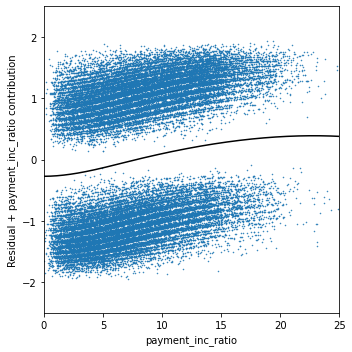

In [38]:
from statsmodels.genmod.generalized_linear_model import GLMResults

def partialResidualPlot(model, df, outcome, feature, fig, ax):
    y_actual = [0 if s == 'default' else 1 for s in df[outcome]]
    y_pred = model.predict(df)
    org_params = model.params.copy()
    zero_params = model.params.copy()
    # set model parametes of other features to 0
    for i, name in enumerate(zero_params.index):
        if feature in name:
            continue
        zero_params[i] = 0.0
    model.initialize(model.model, zero_params)
    feature_prediction = model.predict(df)
    ypartial = -np.log(1/feature_prediction - 1)
    ypartial = ypartial - np.mean(ypartial)
    model.initialize(model.model, org_params)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': -2 * (y_actual - y_pred),
        'ypartial': ypartial/ 2,
    })
    results = results.sort_values(by=['feature'])

    ax.scatter(results.feature, results.residual, marker=".", s=72./fig.dpi)
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(results, loan_data, 'outcome', 'payment_inc_ratio', fig, ax)
ax.set_xlim(0, 25)
ax.set_ylim(-2.5, 2.5)


plt.tight_layout()
plt.show()

The estimated fit, shown by the line, goes between two sets of point clouds. The top cloud corresponds to a response of 1 (defaulted loans), and the bottom cloud corresponds to a response of 0 (loans paid off). This is very typical of residuals from a logistic regression since the output is binary. The prediction is measured as the logit (log of the odds ratio), which will always be some finite value. The actual value, an absolute 0 or 1, corresponds to an infinite logit, either positive or negative, so the residuals (which get added to the fitted value) will never equal 0. Hence the plotted points lie in clouds either above or below the fitted line in the partial residual plot. Partial residuals in logistic regression, while less valuable than in regression, are still useful to confirm nonlinear behavior and identify highly influential records

## 5.4 Evaluating classification models

Accuracy: The percent or proportion of cases classified correctly. Accuracy = (Sum true positive + Sum true negative) / sample size

### Confusion matrix

The confusion matrix is a table showing the number of correct and incorrect predictions categorized by type of response 

In [44]:
pred = logit_reg.predict(X)
pred_y = logit_reg.predict(X) == 'default'
true_y = y == 'default'
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y

conf_mat = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)], [np.sum(false_pos), np.sum(true_neg)]],
                       index=['Y = default', 'Y = paid off'],
                       columns=['Yhat = default', 'Yhat = paid off'])
conf_mat

,Yhat = default,Yhat = paid off
Y = default,14337,8334
Y = paid off,8149,14522


### The rare class problem

In many cases, there is an imbalance in the classes to be predicted, with one class much more prevalent than the other—for example, legitimate insurance claims versus fraudulent ones, or browsers versus purchasers at a website. The rare class (e.g., the fraudulent claims) is usually the class of more interest and is typically designated 1, in contrast to the more prevalent 0s. In the typical scenario, the 1s are the more important case, in the sense that misclassifying them as 0s is costlier than misclassifying 0s as 1s. For example, correctly identifying a fraudulent insurance claim may save thousands of dollars. On the other hand, correctly identifying a nonfraudulent claim merely saves you the cost and effort of going through the claim by hand with a more careful review (which is what you would do if the claim were tagged as “fraudulent”).

In such cases, unless the classes are easily separable, the most accurate classification model may be one that simply classifies everything as a 0. For example, if only 0.1% of the browsers at a web store end up purchasing, a model that predicts that each browser will leave without purchasing will be 99.9% accurate. However, it will be useless. Instead, we would be happy with a model that is less accurate overall but is good at picking out the purchasers, even if it misclassifies some nonpurchasers along the way.

### Precision, recall, and specificity

Precision = TP/(TP + FP)

Recall (Sensitivity) = TP / (TP + FN)

Specificity = TN / (TN + FP)

In [46]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

conf_mat = confusion_matrix(y, logit_reg.predict(X))

print('Precision', conf_mat[0, 0] / sum(conf_mat[:, 0]))
print('Recall', conf_mat[0, 0] / sum(conf_mat[0, :]))
print('Specificity', conf_mat[1, 1] / sum(conf_mat[1, :]))

precision_recall_fscore_support(y, logit_reg.predict(X), labels=['default', 'paid off'])

Precision 0.6375967268522637
Recall 0.6323938070662961
Specificity 0.640554011733051


(array([0.63759673, 0.63536927]),
 array([0.63239381, 0.64055401]),
 array([0.63498461, 0.63795111]),
 array([22671, 22671]))

In [47]:
precision_recall_fscore_support(y, logit_reg.predict(X), 
                                labels=['default', 'paid off'])

(array([0.63759673, 0.63536927]),
 array([0.63239381, 0.64055401]),
 array([0.63498461, 0.63795111]),
 array([22671, 22671]))

### ROC curve

The metric that captures this trade-off is the “Receiver Operating Characteristics” curve, usually referred to as the ROC curve. The ROC curve plots recall (sensitivity) on the y-axis against specificity on the x-axis. The ROC curve shows the trade-off between recall and specificity as you change the cutoff to determine how to classify a record. Sensitivity (recall) is plotted on the y-axis, and you may encounter two forms in which the x-axis is labeled:
1. Specificity plotted on the x-axis, with 1 on the left and 0 on the right
2. 1-Specificity plotted on the x-axis, with 0 on the left and 1 on the right

The curve looks identical whichever way it is done. The process to compute the ROC curve is:
1. Sort the records by the predicted probability of being a 1, starting with the most probable and ending with the least probable.
2. Compute the cumulative specificity and recall based on the sorted records.

Text(0, 0.5, 'recall')

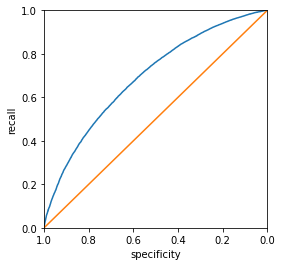

In [49]:
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:,0],pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})
ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)

ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')

**Precision-recall curve**: In addition to ROC curves, it can be illuminating to examine the precision-recall (PR) curve. PR curves are computed in a similar way except that the data is ordered from least to most probable and cumulative precision and recall statistics are computed. PR curves are especially useful in evaluating data with highly unbalanced outcomes

### AUC

AUC is simply the total area under the ROC curve. The larger the value of AUC, the more effective the classifier. An AUC of 1 indicates a perfect classifier: it gets all the 1s correctly classified, and it doesn’t misclassify any 0s as 1s.

A completely ineffective classifier—the diagonal line—will have an AUC of 0.5.

In [50]:
print(np.sum(roc_df.recall[:-1] * np.diff(1 - roc_df.specificity)))
print(roc_auc_score([1 if yi == 'default' else 0 for yi in y], logit_reg.predict_proba(X)[:, 0]))

0.6917107135725116
0.6917107913974233


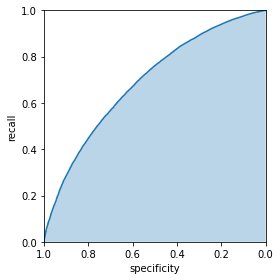

In [51]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:,0], 
                                 pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
# ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
ax.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.3)


plt.tight_layout()
plt.show()

False positive rate confusion: False positive/negative rates are often confused or conflated with specificity or sensitivity (even in publications and software!). Sometimes the false positive rate is defined as the proportion of true negatives that test positive. In many cases (such s network intrusion detection), the term is used to refer to the proportion of ositive signals that are true negatives

### Lift

The concept of lift lets you defer answering the question that what is the optimum cutoff. Instead, you consider the records in order of their predicted probability of being 1s. Say, of the top 10% classified as 1s, how much better did the algorithm do, compared to the benchmark of simply picking blindly? If you can get 0.3% response in this top decile instead of the 0.1% you get overall by picking randomly, the algorithm is said to have a lift (also called gains) of 3 in the top decile. A lift chart (gains chart) quantifies this over the range of the data. It can be produced decile by decile, or continuously over the range of the data.

To compute a lift chart, you first produce a cumulative gains chart that shows the recall on the y-axis and the total number of records on the x-axis. The lift curve is the ratio of the cumulative gains to the diagonal line corresponding to random selection. Decile gains charts are one of the oldest techniques in predictive modeling, dating from the days before internet commerce. They were particularly popular among direct mail professionals. Direct mail is an expensive method of advertising if applied indiscriminately, and advertisers used predictive models (quite simple ones, in the early days) to identify the potential customers with the likeliest prospect of payoff.

**Uplift:** Sometimes the term uplift is used to mean the same thing as lift. An alternate meaning is used in a more restrictive setting, when an A/B test has been conducted and the treatment (A or B) is then used as a predictor variable in a predictive model. The uplift is the improvement in response predicted for an individual case with treatment A versus treatment B. This is determined by scoring the individual case first with the predictor set to A, and then again with the predictor toggled to B. Marketers and political campaign consultants use this method to determine which of two messaging treatments should be used with which customers or voters

A lift curve lets you look at the consequences of setting different probability cutoffs for classifying records as 1s. It can be an intermediate step in settling on an appropriate cutoff level. For example, a tax authority might have only a certain amount of resources that it can spend on tax audits, and it wants to spend them on the likeliest tax cheats. With its resource constraint in mind, the authority would use a lift chart to estimate where to draw the line between tax returns selected for audit and those left alone

## 5.5 Strategies for imbalanced data

### Undersampling

If you have enough data, as is the case with the loan data, one solution is to undersample (or downsample) the prevalent class, so the data to be modeled is more balanced between 0s and 1s. The basic idea in undersampling is that the data for the dominant class has many redundant records. Dealing with a smaller, more balanced data set yields benefits in model performance, and it makes it easier to prepare the data and to explore and pilot models.

In [64]:
full_train_set = pd.read_csv('/Users/boyuan/Desktop/OneDrive/practical-statistics-for-data-scientists-master/data/full_train_set.csv.gz', compression = 'gzip')
print('percentage of loans in default: ', 100 * np.mean(full_train_set.outcome == 'default'))

percentage of loans in default:  18.894546909248504


In [65]:
full_train_set.head()

,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,home_ownership,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_
0,Fully Paid,5000,36 months,24000,27.65,8.14350,13648.0,83.7,credit_card,RENT,1,1,3,5.4,paid off,11,credit_card,RENT,> 1 Year
1,Charged Off,2500,60 months,30000,1.00,2.39320,1687.0,9.4,car,RENT,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year
2,Fully Paid,2400,36 months,12252,8.72,8.25955,2956.0,98.5,small_business,RENT,1,1,2,5.0,paid off,11,small_business,RENT,> 1 Year
3,Fully Paid,10000,36 months,49200,20.00,8.27585,5598.0,21.0,other,RENT,1,1,10,4.2,paid off,11,other,RENT,> 1 Year
4,Fully Paid,5000,36 months,36000,11.20,5.21533,7963.0,28.3,wedding,RENT,1,1,9,6.8,paid off,4,other,RENT,> 1 Year


In [62]:
print(full_train_set.shape)

(119987, 19)


In [66]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

X = pd.get_dummies(full_train_set[predictors], prefix = '', prefix_sep = '', drop_first = True)
y = full_train_set[outcome]

full_model = LogisticRegression(penalty = 'l2', C = 1e42, solver = 'liblinear')
full_model.fit(X, y)
print('percentage of loans predicted to defaul:', 100 * np.mean(full_model.predict(X) == 'default'))

percentage of loans predicted to defaul: 1.0134431230049923


### Oversampling and up/down weighting

One criticism of the undersampling method is that it throws away data and is not using all the information at hand. If you have a relatively small data set, and the rarer class contains a few hundred or a few thousand records, then undersampling the dominant class has the risk of throwing out useful information. In this case, instead of downsampling the dominant case, you should oversample (upsample) the rarer class by drawing additional rows with replacement (bootstrapping).

You can achieve a similar effect by weighting the data. Many classification algorithms take a weight argument that will allow you to up/down weight the data.

In [67]:
default_wt = 1 / np.mean(full_train_set.outcome == 'default')
default_wt

5.292532309999559

In [71]:
wt = [default_wt if outcome == 'default' else 1 for outcome in full_train_set.outcome]
wt[0:10]

[1, 5.292532309999559, 1, 1, 1, 1, 5.292532309999559, 5.292532309999559, 1, 1]

In [73]:
full_model = LogisticRegression(penalty = 'l2', C = 1e42, solver = 'liblinear')
full_model.fit(X, y, sample_weight = wt)
print('percentage of loans predicted to default (weighting):', 100 * np.mean(full_model.predict(X) == 'default'))

percentage of loans predicted to default (weighting): 61.628343070499305


The weights for loans that default are set to 1/p, where p is the probability of default. The nondefaulting loans have a weight of 1. The sums of the weights for the defaulting loans and nondefaulting loans are roughly equal

Weighting provides an alternative to both upsampling the rarer class and downsampling the dominant class

**Adapting the loss function:** Many classification and regression algorithms optimize a certain criteria or loss function. For example, logistic regression attempts to minimize the deviance. In the literature, some propose to modify the loss function in order to avoid the problems caused by a rare class. In practice, this is hard to do: classification algorithms can be complex and difficult to modify. Weighting is an easy way to change the loss function, discounting errors for records with low weights in favor of records with higher weights.

### Data generation

A variation of upsampling via bootstrapping is data generation by perturbing existing records to create new records. The intuition behind this idea is that since we observe only a limited set of instances, the algorithm doesn’t have a rich set of information to build classification “rules.” By creating new records that are similar but not identical to existing records, the algorithm has a chance to learn a more robust set of rules. This notion is similar in spirit to ensemble statistical models such as boosting and bagging

The idea gained traction with the publication of the SMOTE algorithm, which stands for “Synthetic Minority Oversampling Technique.” The SMOTE algorithm finds a record that is similar to the record being upsampled and creates a synthetic record that is a randomly weighted average of the original record and the neighboring record, where the weight is generated separately for each predictor. The number of synthetic oversampled records created depends on the oversampling ratio required to bring the data set into approximate balance with respect to outcome classes.

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print('percentage of loans in default (SMOTE resampled): ', 
      100 * np.mean(y_resampled == 'default'))

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X_resampled, y_resampled)
print('percentage of loans predicted to default (SMOTE): ', 
      100 * np.mean(full_model.predict(X) == 'default'))

In [ ]:
X_resampled, y_resampled = ADASYN().fit_resample(X, y)
print('percentage of loans in default (ADASYN resampled): ', 
      100 * np.mean(y_resampled == 'default'))

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X_resampled, y_resampled)
print('percentage of loans predicted to default (ADASYN): ', 
print(      100 * np.mean(full_model.predict(X) == 'default')))

### Cost-based classification

Often, an estimated cost can be assigned to false positives versus false negatives, and it is more appropriate to incorporate these costs to determine the best cutoff when classifying 1s and 0s. For example, suppose the expected cost of a default of a new loan is C and the expected return from a paid-off loan is R. Then the expected return for that loan is: expected return = P(Y = 0) × R + P(Y = 1) × C

### Exploring the predictions

In [82]:
from sklearn.tree import DecisionTreeClassifier
from pygam import LinearGAM, s, f, l

loan3000 = pd.read_csv('/Users/boyuan/Desktop/OneDrive/practical-statistics-for-data-scientists-master/data/loan3000.csv')

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy', 
                                   min_impurity_decrease=0.003)
loan_tree.fit(X, y)

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)

logit_reg = LogisticRegression(penalty="l2", solver='liblinear')
logit_reg.fit(X, y)

## model
gam = LinearGAM(s(0) + s(1))
print(gam.gridsearch(X.values, [1 if yi == 'default' else 0 for yi in y]))

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + intercept, 
   tol=0.0001, verbose=False)


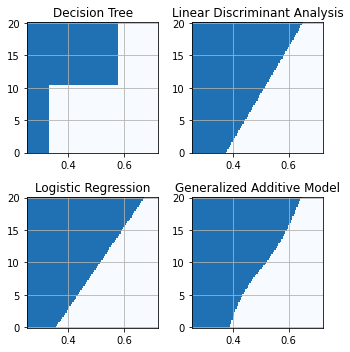

In [83]:
models = {
    'Decision Tree': loan_tree,
    'Linear Discriminant Analysis': loan_lda,
    'Logistic Regression': logit_reg,
    'Generalized Additive Model': gam,
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))

xvalues = np.arange(0.25, 0.73, 0.005)
yvalues = np.arange(-0.1, 20.1, 0.1)
xx, yy = np.meshgrid(xvalues, yvalues)
X = np.c_[xx.ravel(), yy.ravel()]

boundary = {}

for n, (title, model) in enumerate(models.items()):
    ax = axes[n // 2, n % 2]
    predict = model.predict(X)
    if 'Generalized' in title:
        Z = np.array([1 if z > 0.5 else 0 for z in predict])
    else:
        
        Z = np.array([1 if z == 'default' else 0 for z in predict])
    Z = Z.reshape(xx.shape)
    boundary[title] = yvalues[np.argmax(Z > 0, axis=0)]
    boundary[title][Z[-1,:] == 0] = yvalues[-1]

    c = ax.pcolormesh(xx, yy, Z, cmap='Blues', vmin=0.1, vmax=1.3)
    ax.set_title(title)
    ax.grid(True)

plt.tight_layout()
plt.show()

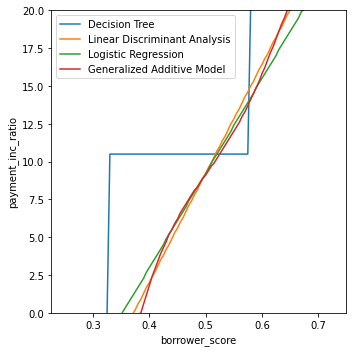

In [88]:
boundary['borrower_score'] = xvalues
boundaries = pd.DataFrame(boundary)

fig, ax = plt.subplots(figsize=(5, 5))
boundaries.plot(x='borrower_score', ax=ax)
ax.set_ylabel('payment_inc_ratio')
ax.set_ylim(0, 20)


plt.tight_layout()
plt.show()